# 06.04.2021 - SXCT: from data collection to results
Lecture material for the DCH423 course - Synchrotron Radiation (SR) enabled research in Heritage Sciences and Archaeology.
## Tomographic reconstruction with TomoPy (demo)

Author: [Gianluca Iori](mailto:gianthk.iori@gmail.com)<br />
Created on: 06-11-2020 <br />
Modified on: 29-03-2021 <br />
---

#### Preliminary operations:
TomoPy must be correctly installed and activated in order to run this example.

List conda environments:
`conda env list`

Activate TomoPy kernel in Jupyter:
`source activate tomopy`

Instal the tomopy_source conda env to ipython kernel: 
`python -m ipykernel install --user --name tomopy_source --display-name "conda (tomopy_source)"`

Launch Jupyter: 
`jupyter notebook &`
---

#### Import and initialization statements

In [17]:
import os
import dxchange
import tomopy
import numpy as np
import h5py
import matplotlib
import matplotlib.pyplot as plt

In [18]:
matplotlib.rcParams['figure.dpi'] = 120

Input data file

In [19]:
h5file = "/home/gianthk/Data/StefanFly_test/test_00_/test_00_.h5"

---
#### Read HDF5 dataset acquired at the TOMCAT beamline of SLS
The `.read_aps_32id()` method of DXchange can read TOMCAT .h5 data

In [20]:
# read all projections
projs, flats, darks, theta = dxchange.read_aps_32id(h5file, exchange_rank=0)

# read one every 10 projections between 1 and 1000
# projs, flats, darks, theta = dxchange.read_aps_32id(h5file, exchange_rank=0, proj=[1, 1000, 10])

Inspect shape and type of loaded data

In [5]:
print(projs.shape[:])
print(projs.dtype)

(1001, 962, 960)
uint16


Display one projection

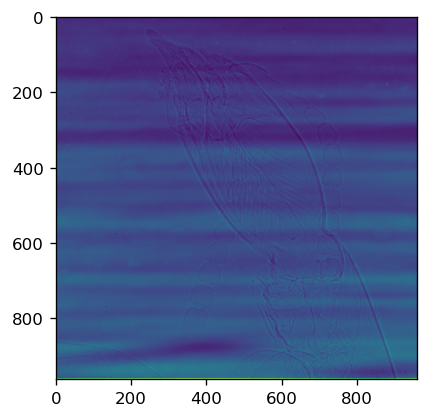

In [21]:
plt.imshow(projs[200, :, :])
plt.show()

Display one sinogram

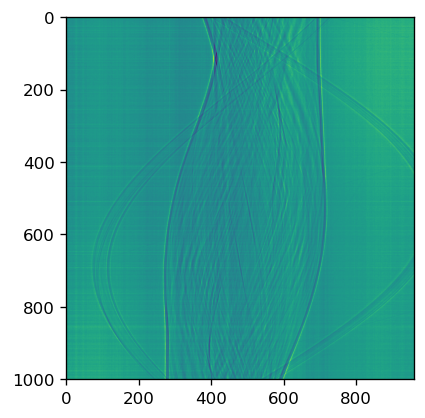

In [22]:
plt.imshow(projs[:, 450, :])
plt.show()

#### Flat field correction

In [23]:
projs = tomopy.normalize(projs, flats, darks)

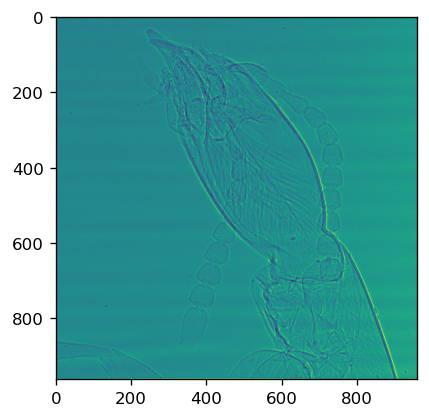

In [24]:
plt.imshow(projs[200, :, :])
plt.show()

#### Calculate $ -log(projs) $ to linearize transmission tomography data.

In [25]:
projs = tomopy.minus_log(projs)

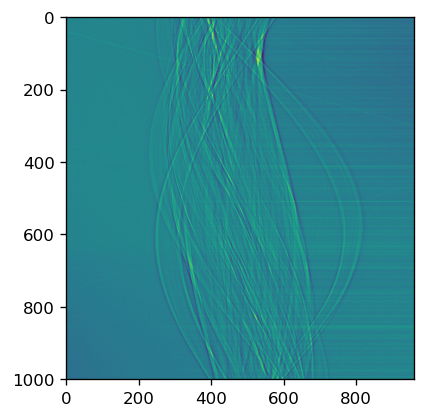

In [11]:
plt.imshow(projs[:, 200, :])
plt.show()

#### Automatic detect Center Of Rotation (COR)

In [12]:
COR = tomopy.find_center_vo(projs)
print(COR)

486.75


In [12]:
COR = 486.75

#### Reconstruction with CPU
Algorithm: `gridrec`

In [13]:
recon = tomopy.recon(projs, theta, center=COR, algorithm='gridrec', sinogram_order=False)

Reconstructing 8 slice groups with 8 master threads...


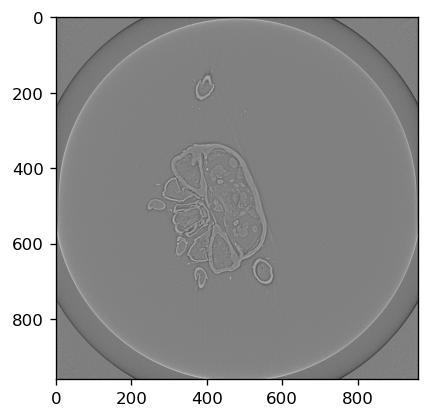

In [14]:
plt.imshow(recon[200, :, :], cmap='gray')
plt.show()

#### Apply circular mask

In [15]:
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)

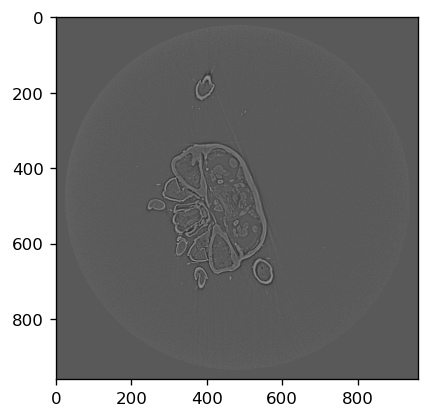

In [16]:
plt.imshow(recon[200, :, :], cmap='gray')
plt.show()

Inspect the reconstruction with itkwidget

In [25]:
from itkwidgets import view
viewer = view(recon, ui_collapsed=True)
viewer.interpolation = False
# uncomment line below to launch itk viewer
# viewer

#### Write output Tiff stack as `uint8`
Specify output reconstruction path

In [17]:
path_recon = "/home/gianthk/Data/StefanFly_test/test_00_/"

In [19]:
import recon_utils
fileout = path_recon+'recon/data.tiff'
dxchange.writer.write_tiff_stack(recon_utils.touint8(recon), fname=fileout, dtype='uint8', axis=0, digit=5, start=0, overwrite=True)

Manual reconstruction with a set of different **CORs**

In [20]:
tomopy.write_center(projs, theta, dpath=path_recon+'COR', cen_range=[482, 492, 0.5], ind=500, mask=True, ratio=1.0, algorithm='gridrec', filter_name='parzen')

Reconstructing 20 slice groups with 8 master threads...


---
#### Phase retrieval

In [22]:
projs_phase = tomopy.retrieve_phase(projs, pixel_size=1e-4*1.625, dist=30, energy=22, alpha=1e-3, pad=True, ncore=None, nchunk=None)

#### Reconstruction with CPU
Algorithm: `gridrec`

In [23]:
recon_phase = tomopy.recon(projs_phase, theta, center=COR, algorithm='gridrec', sinogram_order=False)

Reconstructing 8 slice groups with 8 master threads...


In [25]:
recon_phase = tomopy.circ_mask(recon_phase, axis=0, ratio=0.95)

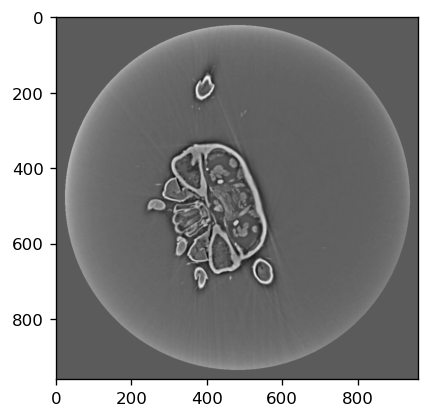

In [26]:
plt.imshow(recon_phase[200, :, :], cmap='gray')
plt.show()

#### Write output Tiff stack as `uint8`
Specify output reconstruction path

In [27]:
fileout = path_recon+'recon_phase/data.tiff'
dxchange.writer.write_tiff_stack(recon_utils.touint8(recon_phase), fname=fileout, dtype='uint8', axis=0, digit=5, start=0, overwrite=True)